In [12]:
import pandas as pd
import spacy

# ================================
# CONFIGURATION
# ================================
INPUT = "makeorg_biodiversite.xlsx"
OUTPUT = "output.xlsx"
TEXT_COL = "Proposition"
NEW_COL = "Tokens_lemmas"
MODEL = "fr_core_news_sm"

# ================================
# LOAD MODEL (auto-download if missing)
# ================================
try:
    nlp = spacy.load(MODEL)
except OSError:
    print(f"Downloading {MODEL} ...")
    from spacy.cli import download
    download(MODEL)
    nlp = spacy.load(MODEL)

# ================================
# READ DATA
# ================================
df = pd.read_excel(INPUT)

if TEXT_COL not in df.columns:
    raise ValueError(f"Column '{TEXT_COL}' not found. Available: {list(df.columns)}")

# Optional: remove leading “Il faut …”
df[TEXT_COL] = df[TEXT_COL].str.replace(r'^\s*Il faut\s+', '', case=False, regex=True)

# ================================
# DEFINE CLEANING FUNCTION
# ================================
def doc_to_lemmas(doc):
    """
    Clean and lemmatize text automatically using spaCy:
    - Removes punctuation, numbers, and stopwords (articles, pronouns, etc.)
    - Keeps meaningful lemmas (nouns, verbs, adjectives, adverbs)
    """
    lemmas = []
    for tok in doc:
        if tok.is_punct or tok.is_space:
            continue
        if tok.is_stop:  # automatic stopword detection 
            continue
        if tok.like_num or any(ch.isdigit() for ch in tok.text):
            continue
        if tok.is_alpha or any(ch.isdigit() for ch in tok.text):
            lemma = tok.lemma_.lower()
            lemmas.append(lemma)
    return lemmas

# ================================
# PROCESS TEXTS
# ================================
texts = df[TEXT_COL].astype(str).fillna("").tolist()
docs = nlp.pipe(texts, disable=["parser", "ner"])  # faster

df[NEW_COL] = [doc_to_lemmas(doc) for doc in docs]

# ================================
# SAVE RESULT
# ================================
df.to_excel(OUTPUT, index=False)

# show first few samples
print(df[[TEXT_COL, NEW_COL]].head(10))

                                         Proposition  \
0  favoriser le reboisement urbain afin de baisse...   
1  stopper l’érosion des haies (-23 500km par an)...   
2  stopper l'importation de produits agricoles tr...   
3  réintégrer les arbres et les haies dans l’agri...   
4  empêcher l'importation de produits agricoles q...   
5  replanter des haies pour éviter l'érosion des ...   
6  punir sévèrement ceux qui déversent des déchet...   
7  replanter des haies autour des champs afin de ...   
8  préserver, restaurer, maintenir en bon état éc...   
9  soutenir une agriculture protectrice du vivant...   

                                       Tokens_lemmas  
0  [favoriser, reboisement, urbain, baisser, temp...  
1  [stopper, érosion, haie, kilomètre, an, puisse...  
2  [stopper, importation, produit, agricole, trai...  
3  [réintégrer, arbre, haie, agriculture, produir...  
4  [empêcher, importation, produit, agricole, tra...  
5  [replanter, haie, éviter, érosion, sol, permet... 

In [13]:
from collections import Counter
from itertools import chain

# Flatten all token lists into one big list
all_tokens = list(chain.from_iterable(df["Tokens_lemmas"]))

# Count frequency of each word
vocab_counter = Counter(all_tokens)

# Vocabulary size = number of unique words
vocab_size = len(vocab_counter)
print(f"Vocabulary size: {vocab_size} unique lemmas")

# Show 20 most frequent words
print("\n Top 20 most frequent words:")
for word, freq in vocab_counter.most_common(20):
    print(f"{word:20s} {freq}")

Vocabulary size: 6178 unique lemmas

 Top 20 most frequent words:
biodiversité         690
interdire            475
eau                  352
animal               336
faire                328
chasse               315
arrêter              313
nature               311
zone                 274
créer                266
arbre                265
espèce               260
protéger             259
espace               243
limiter              230
ville                218
haie                 210
naturel              208
produit              204
favoriser            203


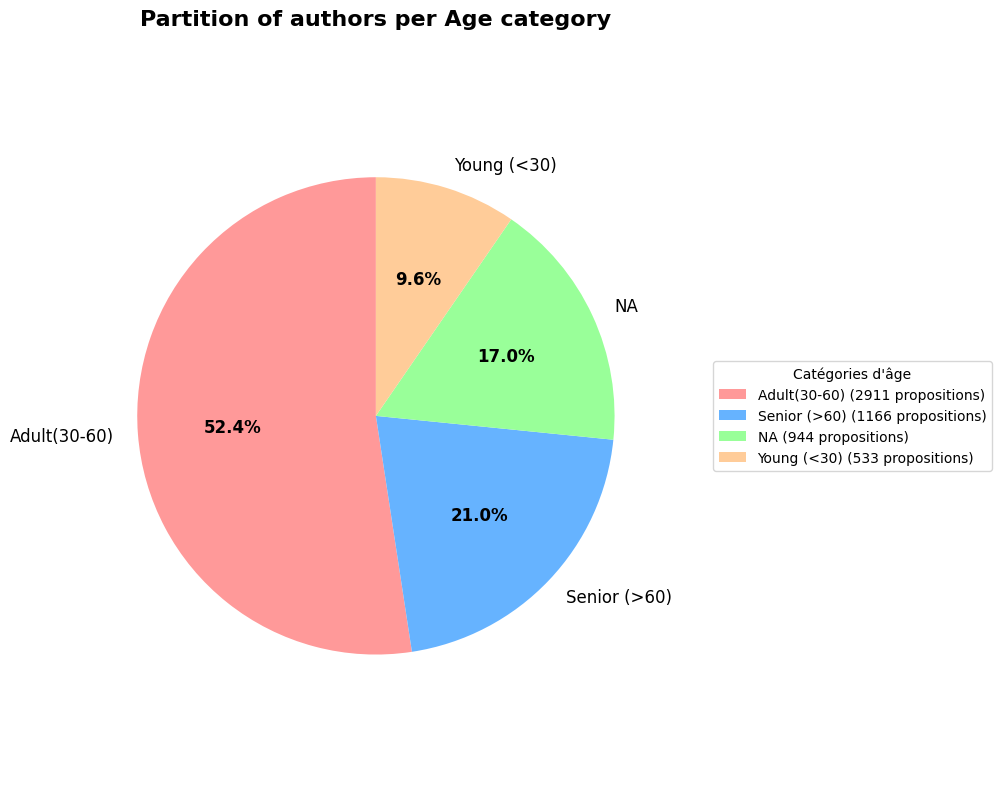

STATISTICS PER AGE CATEGORY
• Adult(30-60): 2911 propositions (52.4%)
• Senior (>60): 1166 propositions (21.0%)
• NA: 944 propositions (17.0%)
• Young (<30): 533 propositions (9.6%)

 AGE STATISTICS:
• Average age: 49.5 ages
• Median age: 51.0 ages
• Youngest: 8 ages
• Oldest: 124 ages
• Standard deviation: 14.9 ages


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use('default')
sns.set_palette("Set2")

# Load data
df = pd.read_excel("makeorg_biodiversite.xlsx")

# Age categories
def categorize_age(age):
    if pd.isna(age):
        return 'NA'
    elif age < 30:
        return 'Young (<30)'
    elif age <= 60:
        return 'Adult(30-60)'
    else:
        return 'Senior (>60)'

# Categorization application
if 'Âge' in df.columns:
    df['Catégorie Âge'] = df['Âge'].apply(categorize_age)
    
    # Compute distributions
    age_cat_counts = df['Catégorie Âge'].value_counts()
    
    # Pie plot
    plt.figure(figsize=(10, 8))
    
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    wedges, texts, autotexts = plt.pie(age_cat_counts.values, 
                                      labels=age_cat_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors[:len(age_cat_counts)],
                                      startangle=90,
                                      textprops={'fontsize': 12})
    
    # Percentage 
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    plt.title('Partition of authors per Age category', 
              fontsize=16, fontweight='bold', pad=20)
    
    legend_labels = [f'{label} ({count} propositions)' 
                    for label, count in zip(age_cat_counts.index, age_cat_counts.values)]
    plt.legend(wedges, legend_labels, 
              title="Catégories d'âge",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("STATISTICS PER AGE CATEGORY")
    print("=" * 40)
    total_proposals = len(df)
    for category, count in age_cat_counts.items():
        percentage = (count / total_proposals) * 100
        print(f"• {category}: {count} propositions ({percentage:.1f}%)")
    
    # Print Statistics for original age
    print(f"\n AGE STATISTICS:")
    age_stats = df['Âge'].describe()
    print(f"• Average age: {age_stats['mean']:.1f} ages")
    print(f"• Median age: {age_stats['50%']:.1f} ages")
    print(f"• Youngest: {age_stats['min']:.0f} ages")
    print(f"• Oldest: {age_stats['max']:.0f} ages")
    print(f"• Standard deviation: {age_stats['std']:.1f} ages")

else:
    print(" 'Âge' column is not available in the dataset")

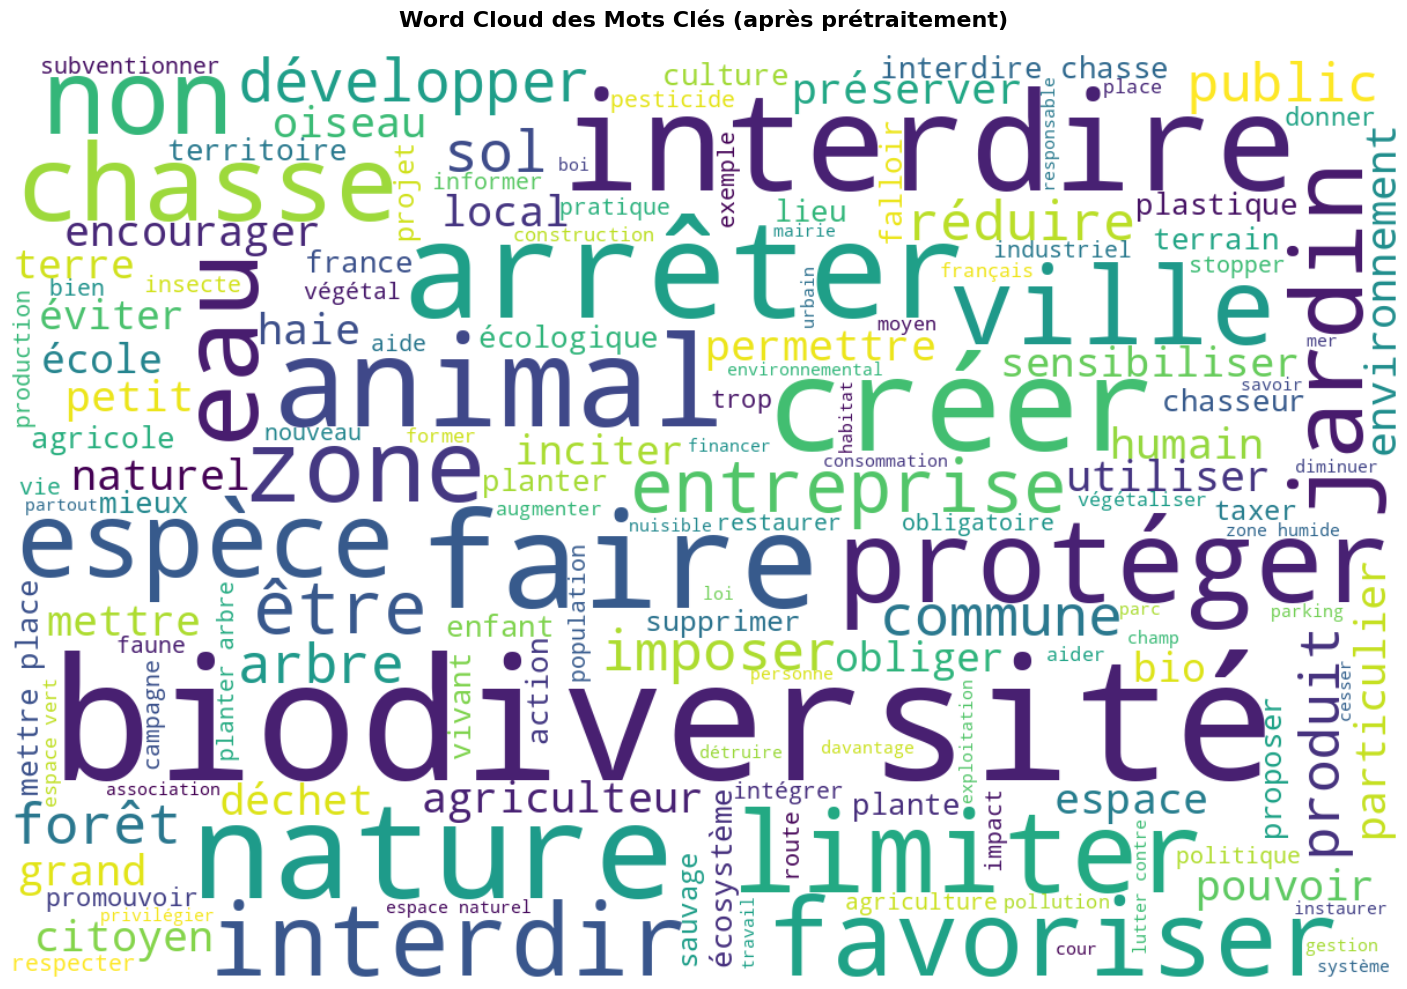

Vocabulary size: 6178 unique lemmas

 Top 30 most frequent words:
----------------------------------------
biodiversité         690 occurrences
interdire            475 occurrences
eau                  352 occurrences
animal               336 occurrences
faire                328 occurrences
chasse               315 occurrences
arrêter              313 occurrences
nature               311 occurrences
zone                 274 occurrences
créer                266 occurrences
arbre                265 occurrences
espèce               260 occurrences
protéger             259 occurrences
espace               243 occurrences
limiter              230 occurrences
ville                218 occurrences
haie                 210 occurrences
naturel              208 occurrences
produit              204 occurrences
favoriser            203 occurrences
mettre               202 occurrences
public               195 occurrences
non                  179 occurrences
interdir             179 occurrences
sauva

In [8]:
# ================================
# CREATE WORD CLOUD FROM PREPROCESSED TOKENS
# ================================

# Flatten all token lists into one big list
all_tokens = list(chain.from_iterable(df["Tokens_lemmas"]))

# Count frequency of each word
vocab_counter = Counter(all_tokens)

# Create a string of all tokens for word cloud
all_text = ' '.join(all_tokens)

# Create and generate word cloud
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    max_words=150,
    colormap='viridis',
    relative_scaling=0.5,
    random_state=42
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud des Mots Clés (après prétraitement)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ================================
# DISPLAY STATISTICS
# ================================

# Vocabulary size
vocab_size = len(vocab_counter)
print(f"Vocabulary size: {vocab_size} unique lemmas")

# Show top 30 most frequent words
print("\n Top 30 most frequent words:")
print("-" * 40)
for word, freq in vocab_counter.most_common(30):
    print(f"{word:20s} {freq:3d} occurrences")

PROPOSAL LENGTH DISTRIBUTION
Total number of proposals: 5554

 Character length statistics:
   • Mean: 112 characters
   • Median: 123 characters
   • Minimum: 23 characters
   • Maximum: 140 characters
   • Standard deviation: 28.3 characters

Word length statistics:
   • Mean: 18 words
   • Median: 19 words
   • Minimum: 4 words
   • Maximum: 31 words
   • Standard deviation: 4.7 words


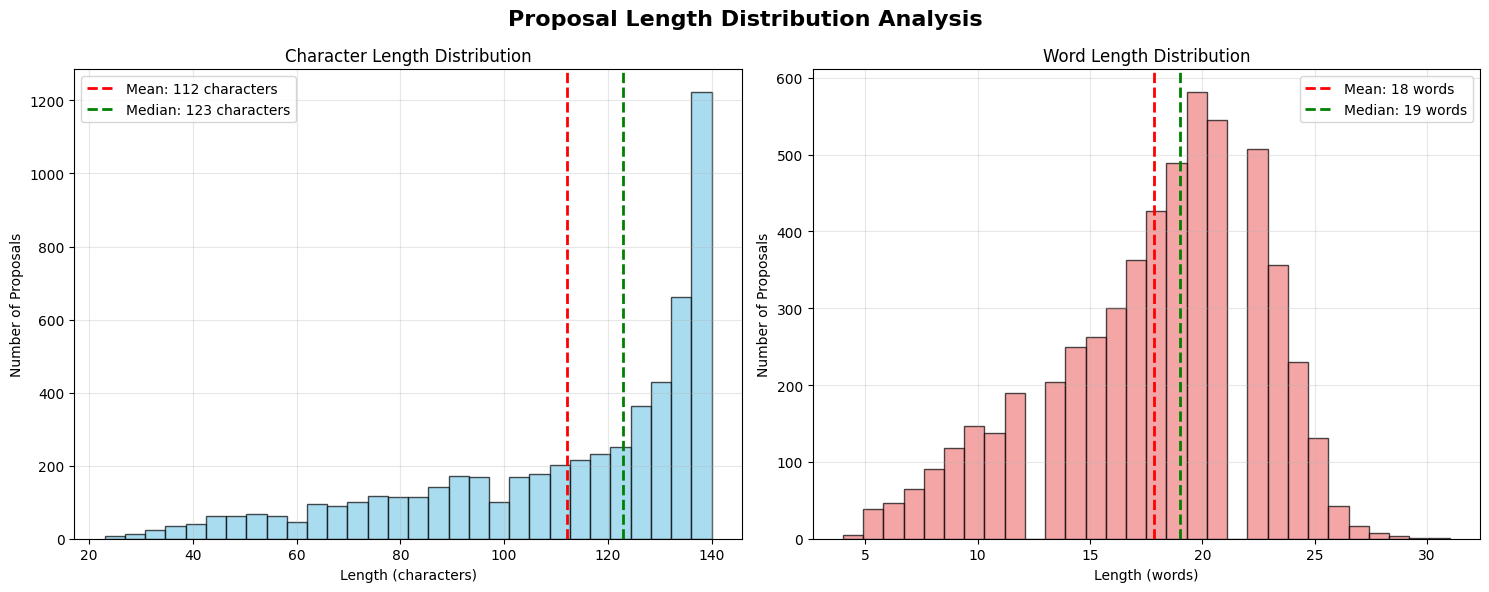


LENGTH CATEGORIES (in words):
   • Very short (<20 words): 3132 proposals (56.4%)
   • Short (20-40 words): 2422 proposals (43.6%)
   • Medium (40-60 words): 0 proposals (0.0%)
   • Long (60-80 words): 0 proposals (0.0%)
   • Very long (≥80 words): 0 proposals (0.0%)

ADDITIONAL STATISTICS:
   • Character length range: 23 - 140 characters
   • Word length range: 4 - 31 words
   • Interquartile range (characters): 42 characters
   • Interquartile range (words): 6 words


In [ ]:
# Style configuration
plt.style.use('default')
sns.set_palette("viridis")

# Load data
df = pd.read_excel("makeorg_biodiversite.xlsx")

# Calculate length in characters for each proposal
df['Character_Length'] = df['Proposition'].str.len()

# Calculate length in words for each proposal
df['Word_Length'] = df['Proposition'].str.split().str.len()

# Descriptive statistics
char_stats = df['Character_Length'].describe()
word_stats = df['Word_Length'].describe()

print("PROPOSAL LENGTH DISTRIBUTION")
print("=" * 50)
print(f"Total number of proposals: {len(df)}")
print(f"\n Character length statistics:")
print(f"   • Mean: {char_stats['mean']:.0f} characters")
print(f"   • Median: {char_stats['50%']:.0f} characters")
print(f"   • Minimum: {char_stats['min']:.0f} characters")
print(f"   • Maximum: {char_stats['max']:.0f} characters")
print(f"   • Standard deviation: {char_stats['std']:.1f} characters")

print(f"\nWord length statistics:")
print(f"   • Mean: {word_stats['mean']:.0f} words")
print(f"   • Median: {word_stats['50%']:.0f} words")
print(f"   • Minimum: {word_stats['min']:.0f} words")
print(f"   • Maximum: {word_stats['max']:.0f} words")
print(f"   • Standard deviation: {word_stats['std']:.1f} words")

# Create the two main distribution charts
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Proposal Length Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Character length histogram
axes[0].hist(df['Character_Length'], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].axvline(char_stats['mean'], color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {char_stats["mean"]:.0f} characters')
axes[0].axvline(char_stats['50%'], color='green', linestyle='--', linewidth=2,
                label=f'Median: {char_stats["50%"]:.0f} characters')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Number of Proposals')
axes[0].set_title('Character Length Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Word length histogram
axes[1].hist(df['Word_Length'], bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
axes[1].axvline(word_stats['mean'], color='red', linestyle='--', linewidth=2,
                label=f'Mean: {word_stats["mean"]:.0f} words')
axes[1].axvline(word_stats['50%'], color='green', linestyle='--', linewidth=2,
                label=f'Median: {word_stats["50%"]:.0f} words')
axes[1].set_xlabel('Length (words)')
axes[1].set_ylabel('Number of Proposals')
axes[1].set_title('Word Length Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display length categories
print(f"\nLENGTH CATEGORIES (in words):")
word_categories = {
    'Very short (<20 words)': len(df[df['Word_Length'] < 20]),
    'Short (20-40 words)': len(df[(df['Word_Length'] >= 20) & (df['Word_Length'] < 40)]),
    'Medium (40-60 words)': len(df[(df['Word_Length'] >= 40) & (df['Word_Length'] < 60)]),
    'Long (60-80 words)': len(df[(df['Word_Length'] >= 60) & (df['Word_Length'] < 80)]),
    'Very long (≥80 words)': len(df[df['Word_Length'] >= 80])
}

for category, count in word_categories.items():
    percentage = (count / len(df)) * 100
    print(f"   • {category}: {count} proposals ({percentage:.1f}%)")

# Additional statistics
print(f"\nADDITIONAL STATISTICS:")
print(f"   • Character length range: {char_stats['min']:.0f} - {char_stats['max']:.0f} characters")
print(f"   • Word length range: {word_stats['min']:.0f} - {word_stats['max']:.0f} words")
print(f"   • Interquartile range (characters): {char_stats['75%'] - char_stats['25%']:.0f} characters")
print(f"   • Interquartile range (words): {word_stats['75%'] - word_stats['25%']:.0f} words")

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Dataset shape: (5554, 9)
Columns: ['Proposition', "Nom d'auteur", 'Âge', 'Département', 'Nb de votes', '% pour', '% contre', '% neutre', 'Tokens_lemmas']
% pour: 0 missing values
% contre: 0 missing values
% neutre: 0 missing values
Clean dataset shape: (5554, 9)

DESCRIPTIVE STATISTICS

% pour:
  Mean: 0.683
  Median: 0.711
  Std: 0.163
  Min: 0.045
  Max: 0.965

% contre:
  Mean: 0.143
  Median: 0.115
  Std: 0.105
  Min: 0.004
  Max: 0.870

% neutre:
  Mean: 0.174
  Median: 0.153
  Std: 0.095
  Min: 0.011
  Max: 0.838


/tmp/ipykernel_8405/3588171970.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_clean[col].dropna() for col in voting_columns],


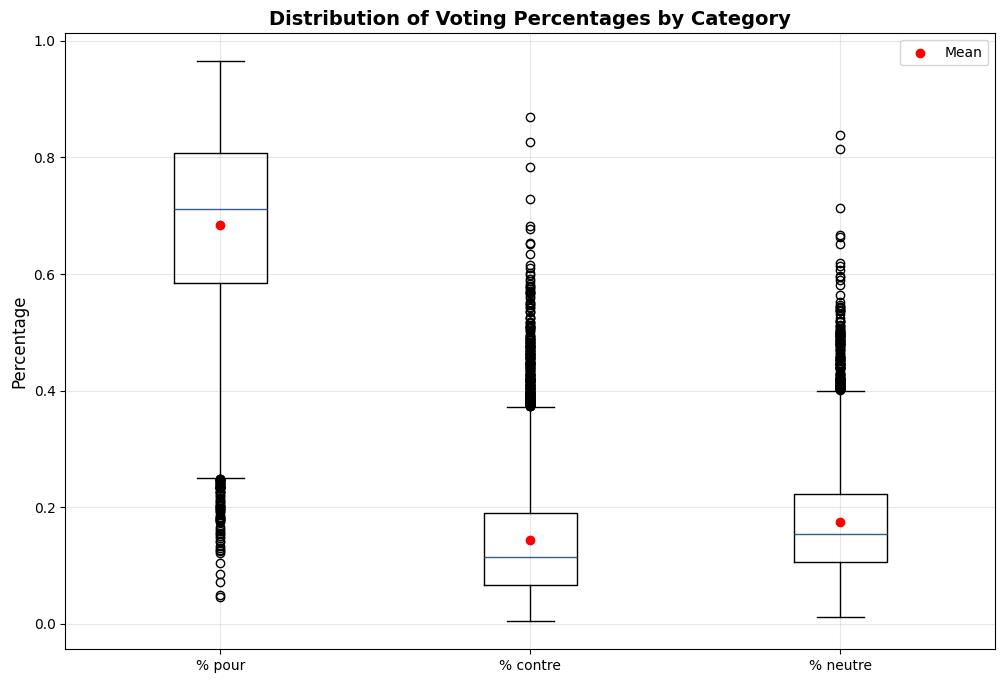

/tmp/ipykernel_8405/3588171970.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Category', y='Percentage', palette='viridis')


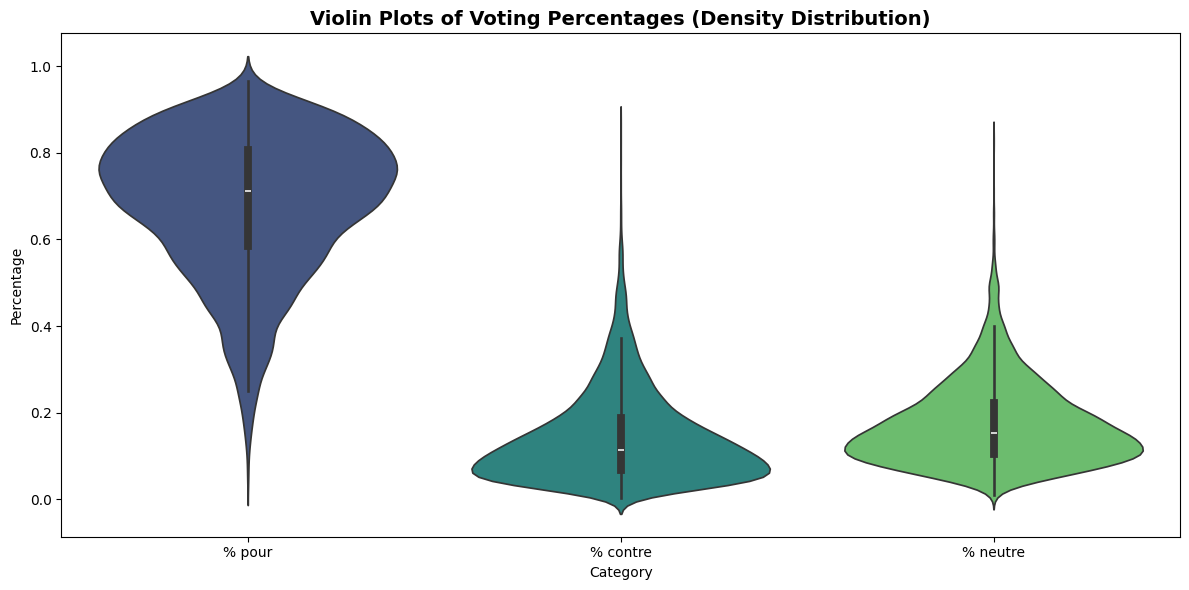

In [ ]:
# ================================
# CONFIGURATION
# ================================
INPUT = "output.xlsx"  
OUTPUT_PLOTS = "voting_distributions.png"

# ================================
# LOAD PREPROCESSED DATA
# ================================
df = pd.read_excel(INPUT)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# ================================
# DATA CLEANING FOR VOTING COLUMNS
# ================================
# Ensure voting columns are numeric and handle any missing values
voting_columns = ['% pour', '% contre', '% neutre']

for col in voting_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"{col}: {df[col].isna().sum()} missing values")

# Remove rows where all voting percentages are missing
df_clean = df.dropna(subset=voting_columns, how='all')

print(f"Clean dataset shape: {df_clean.shape}")

# ====================================
# DESCRIPTIVE STATISTICS OF PERCENTAGE
# ====================================
print("\n" + "="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)

for col in voting_columns:
    if col in df_clean.columns:
        print(f"\n{col}:")
        print(f"  Mean: {df_clean[col].mean():.3f}")
        print(f"  Median: {df_clean[col].median():.3f}")
        print(f"  Std: {df_clean[col].std():.3f}")
        print(f"  Min: {df_clean[col].min():.3f}")
        print(f"  Max: {df_clean[col].max():.3f}")

# ================================
# CREATE BOXPLOTS
# ================================
plt.figure(figsize=(12, 8))

# BOXPLOT: Individual distributions
plt.boxplot([df_clean[col].dropna() for col in voting_columns], 
           labels=voting_columns)
plt.title('Distribution of Voting Percentages by Category', 
          fontsize=14, fontweight='bold')
plt.ylabel('Percentage', fontsize=12)
plt.grid(True, alpha=0.3)

# Add mean points
for i, col in enumerate(voting_columns):
    mean_val = df_clean[col].mean()
    plt.scatter(i+1, mean_val, color='red', zorder=3, label='Mean' if i == 0 else "")

plt.legend()
plt.show()


# ================================
# ADDITIONAL ANALYSIS: VIOLIN PLOTS
# ================================
plt.figure(figsize=(12, 6))
sns.violinplot(data=plot_df, x='Category', y='Percentage', palette='viridis')
plt.title('Violin Plots of Voting Percentages (Density Distribution)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('voting_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()
